In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import time
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.base import clone
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [19]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin,TransformerMixin

# to avoid (hopefully unimportant) warnings
from silence_tensorflow import silence_tensorflow
from absl import logging

silence_tensorflow()
logging.set_verbosity(logging.ERROR)


class MyDynamicKerasRegressor(BaseEstimator, RegressorMixin):
    """
    Custom regressor that wraps a dynamic Keras model for use with scikit-learn pipelines.
    This wrapper is necessary because sometimes (e.g. when using pca in pipeline) the input shape is not clear apriori
    """

    def __init__(self, model, epochs=None, batch_size=None, verbose=0, optimizer="adam", loss=None, metrics=None):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.keras_model = None
        self.history = None


    def fit(self, x, y):
        """fits the parameter"""

        if self.keras_model is None:
            self.keras_model = self.model(input_shape=(x.shape[1],))
            self.keras_model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
            self.history = self.keras_model.fit(x, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

        return self

    def predict(self, x):
        """Predict using the Keras model."""

        if self.keras_model is None:
            raise Exception("The model has not been fitted yet!")
        else:
            predictions = self.keras_model.predict(x, verbose=self.verbose)
            return np.ravel(predictions)

    def score(self, x, y, sample_weight=None):
        """
        Returns the mean squared error on the given test data and labels.
        """
        predictions = self.predict(x)
        mse = np.mean((predictions - y) ** 2)
        return -mse  # Negative MSE because scikit-learn's convention is that higher return values are better

    def get_params(self, deep=True):
        """Get parameters for this estimator."""

        return {
            "model": self.model,
            "epochs": self.epochs,
            "batch_size": self.batch_size,
            "verbose": self.verbose,
            "optimizer": self.optimizer,
            "loss": self.loss,
            "metrics": self.metrics,
        }

    def set_params(self, **params):
        """Set parameters for this estimator."""
        valid_params = self.get_params(deep=True)
        for parameter, value in params.items():
            if parameter in valid_params:
                setattr(self, parameter, value)
        return self


class MyDynamicKerasClassifier(BaseEstimator, ClassifierMixin):
    """
    Custom classifier that wraps a dynamic Keras model for use with scikit-learn pipelines.
    This wrapper is necessary because sometimes (e.g. when using pca in pipeline) the input shape is not clear apriori
    """

    def __init__(self, model, epochs=None, batch_size=None, verbose=0, optimizer="adam", loss=None, metrics=None, cnn=False, cnn_shape_list=None):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        self.cnn = cnn
        self.cnn_shape_list = cnn_shape_list
        self.keras_model = None
        self.history = None

    def fit(self, x, y):
        """fits the parameter"""

        # convert y to numpy array and set classes_
        y = np.array(y)
        self.classes_ = np.unique(y)

        if self.keras_model is None:
            if self.cnn:
                x_new = x.reshape(self.cnn_shape_list)
                self.keras_model = self.model(input_shape=x_new.shape[1:])
                self.keras_model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
                self.history = self.keras_model.fit(x_new, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
            else:
                self.keras_model = self.model(input_shape=(x.shape[1],))
                self.keras_model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
                self.history = self.keras_model.fit(x, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

        return self

    def predict(self, x):
        """Predict using the Keras model."""

        if self.keras_model is None:
            raise Exception("The model has not been fitted yet!")
        elif self.cnn:
            x_new = x.reshape(self.cnn_shape_list)
            probabilities = self.keras_model.predict(x_new, verbose=self.verbose)
        else:
            probabilities = self.keras_model.predict(x, verbose=self.verbose)

        if probabilities.shape[1] == 1:
            # Use 0.5 as the threshold to convert probabilities to binary labels
            return (probabilities > 0.5).astype('int32')
        else:
            # Use argmax for multi-class problems
            return probabilities.argmax(axis=1)

    def get_params(self, deep=True):
        """Get parameters for this estimator."""

        return {
            "model": self.model,
            "epochs": self.epochs,
            "batch_size": self.batch_size,
            "verbose": self.verbose,
            "optimizer": self.optimizer,
            "loss": self.loss,
            "metrics": self.metrics,
            "cnn": self.cnn,
            "cnn_shape_list": self.cnn_shape_list,
        }

    def set_params(self, **params):
        """Set parameters for this estimator."""
        valid_params = self.get_params(deep=True)
        for parameter, value in params.items():
            if parameter in valid_params:
                setattr(self, parameter, value)
        return self

class Selector(BaseEstimator, TransformerMixin):
    """
    Selcects the features (numerical, categorical or all)
    """

    def __init__(self, select):
        """
        select has to be "num features", "cat features" or "all features"
        """

        if select not in ["num features", "cat features", "all features"]:
            raise TypeError("for select only num features, cat features or all features")

        self.select = select
        self.num_attr = None
        self.cat_attr = None

    def fit(self, x: pd.DataFrame, _y=None):
        """fits the parameter"""

        if not isinstance(x, pd.DataFrame):
            raise TypeError("Selector needs Pandas Dataframe!")

        self.num_attr = list(x.select_dtypes(include=[np.number]).columns)
        self.cat_attr = list(x.select_dtypes(exclude=[np.number]).columns)

        return self

    def transform(self, x: pd.DataFrame, _y=None):
        """does the transformation"""

        if not isinstance(x, pd.DataFrame):
            raise TypeError("Selector needs Pandas Dataframe!")

        if self.select == "num features":
            x_new = x[self.num_attr].copy()
        elif self.select == "cat features":
            x_new = x[self.cat_attr].copy()
        elif self.select == "all features":
            x_new = x[self.num_attr + self.cat_attr].copy()
        else:
            raise TypeError("for select only num features, cat features or all features")

        return x_new

    def get_feature_names_out(self):
        """this method is needed, otherwise we cannot use set_ouput"""
        pass

In [20]:
# Load the data
csv_path = r'./../project_1_train.csv'
data = pd.read_csv(csv_path)

max_number_of_nas = 1500
data = data.loc[:, (data.isnull().sum(axis=0) <= max_number_of_nas)]

data.dropna(inplace=True)

# Separate the features and the target variable
y = data['DirectChol']
X = data.drop(columns=['NR', 'BMI', 'BMI_WHO', 'DirectChol'])

# Handle missing values
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(exclude=['number']).columns
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# Encode categorical variables
X = pd.get_dummies(X, columns=cat_cols)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# Convert data types to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')


In [22]:
def DNN_gridsearch3(x, y):
    start = time.time()

    def create_model(input_shape=None):
        keras_model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(units=128, activation='relu', input_shape=input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(units=1, activation='linear')  # Output layer for regression
        ])

        keras_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
        return keras_model

    pipeline_num = Pipeline([
        ("selector", Selector("num features")),  # select numeric attributes
        ("imputer", SimpleImputer(strategy="median")),  # missing values are replaced by column median
        ("scaler", MinMaxScaler()),  # scale to mean 0 and std 1
        ("pca", PCA()),  # dimensionality reduction, optional, adjust as needed
    ])

    base_model = Pipeline([
        ("pipeline_num", pipeline_num),
        ("keras", MyDynamicKerasClassifier(model=create_model, epochs=150, batch_size=32, loss="mean_squared_error", metrics=["mean_absolute_error"])),
    ])

    model_param = [
        {
            "keras__batch_size": [32, 64],  # You can adjust and add more hyperparameters as needed
        }
    ]

    model_gs = GridSearchCV(base_model, model_param, cv=10, n_jobs=-1, scoring="neg_mean_squared_error", error_score='raise')
    model_gs.fit(x, y)

    model = model_gs.best_estimator_
    model_best_params = model_gs.best_params_
    model_predictions = model.predict(x)
    model_new = clone(model)
    model_predictions_cv = cross_val_predict(model_new, x, y, cv=3, n_jobs=-1)

    end = time.time()
    model_time = end - start

    model.named_steps["keras"].keras_model.save("DNN_gridsearch_keras")
    model.steps.pop(-1)  # Remove the Keras model before saving the pipeline
    joblib.dump(model, filename="DNN_gridsearch_without_keras.pkl")  # Save the pipeline without the Keras model

    # Save other results
    with open("model_1_best_params.pkl", "wb") as ff:
        pickle.dump(model_best_params, ff)
    joblib.dump(model_predictions, filename="DNN_gridsearch_predictions.pkl")
    joblib.dump(model_predictions_cv, filename="DNN_gridsearch_predictions_cv.pkl")
    joblib.dump(model_time, filename="DNN_gridsearch_time.pkl")

    return model, model_best_params, model_predictions, model_predictions_cv, model_time

# Note: Ensure the Selector class or a similar method is defined or replace it with appropriate feature selection.


In [23]:
DNN_gridsearch3(X_train, y_train)

(Pipeline(steps=[('pipeline_num',
                  Pipeline(steps=[('selector', Selector(select='num features')),
                                  ('imputer', SimpleImputer(strategy='median')),
                                  ('scaler', MinMaxScaler()),
                                  ('pca', PCA())]))]),
 {'keras__batch_size': 32},
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]),
 array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]),
 138.35988521575928)

In [24]:
import joblib
import pickle
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the saved pipeline and the saved Keras model
model_1 = joblib.load("DNN_gridsearch_without_keras.pkl")  # load pipeline without Keras model
model_1.steps.append(("keras", MyDynamicKerasClassifier(model=tf.keras.models.load_model("DNN_gridsearch_keras"))))

# Load other saved components
# with open("DNN_gridsearch_best_params.pkl", 'rb') as f:
#     model_1_best_params = pickle.load(f)
model_1_predictions = joblib.load("DNN_gridsearch_predictions.pkl")
model_1_time = joblib.load("DNN_gridsearch_time.pkl")

# Compute regression evaluation metrics
mse = mean_squared_error(y_train, model_1_predictions)
rmse = mean_squared_error(y_train, model_1_predictions, squared=False)
mae = mean_absolute_error(y_train, model_1_predictions)
r2 = r2_score(y_train, model_1_predictions)

print("TIME: ", round(model_1_time, 2), " sec\n")
print("Regression Evaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)



TIME:  138.36  sec

Regression Evaluation Metrics:
Mean Squared Error (MSE): 0.2981106190043445
Root Mean Squared Error (RMSE): 0.5459950723260646
Mean Absolute Error (MAE): 0.40919882765087895
R-squared (R2): -0.7892690837344221


In [25]:
from tensorflow.keras.callbacks import EarlyStopping

def DNN_model_with_early_stopping(x_train, y_train, x_val, y_val):
    start = time.time()

    def create_model():
        keras_model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(units=1, activation='linear')  # Output layer for regression
        ])

        keras_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
        return keras_model

    # Create the model
    model = create_model()

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(x_train, y_train, epochs=150, batch_size=32,
                        validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

    end = time.time()
    model_time = end - start

    # Evaluate the model
    mse, mae = model.evaluate(x_val, y_val)
    print(f'Mean Squared Error (MSE) on validation set: {mse}')
    print(f'Mean Absolute Error (MAE) on validation set: {mae}')

    print(f"Training time: {model_time} sec")

    return model, history

# Note: Make sure you have your training and validation sets ready (x_train, y_train, x_val, y_val)
model, history = DNN_model_with_early_stopping(X_train, y_train, X_test, y_test)


Epoch 1/150
118/118 [==============================] - 1s 2ms/step - loss: 2.0001 - mean_absolute_error: 1.1173 - val_loss: 0.3750 - val_mean_absolute_error: 0.4906
Epoch 2/150
118/118 [==============================] - 0s 2ms/step - loss: 0.8244 - mean_absolute_error: 0.7003 - val_loss: 0.1806 - val_mean_absolute_error: 0.3196
Epoch 3/150
118/118 [==============================] - 0s 2ms/step - loss: 0.5615 - mean_absolute_error: 0.5766 - val_loss: 0.1609 - val_mean_absolute_error: 0.3090
Epoch 4/150
118/118 [==============================] - 0s 2ms/step - loss: 0.4992 - mean_absolute_error: 0.5444 - val_loss: 0.1683 - val_mean_absolute_error: 0.3104
Epoch 5/150
118/118 [==============================] - 0s 1ms/step - loss: 0.3931 - mean_absolute_error: 0.4837 - val_loss: 0.1638 - val_mean_absolute_error: 0.3089
Epoch 6/150
118/118 [==============================] - 0s 1ms/step - loss: 0.3469 - mean_absolute_error: 0.4530 - val_loss: 0.1674 - val_mean_absolute_error: 0.3095
Epoch 7/15

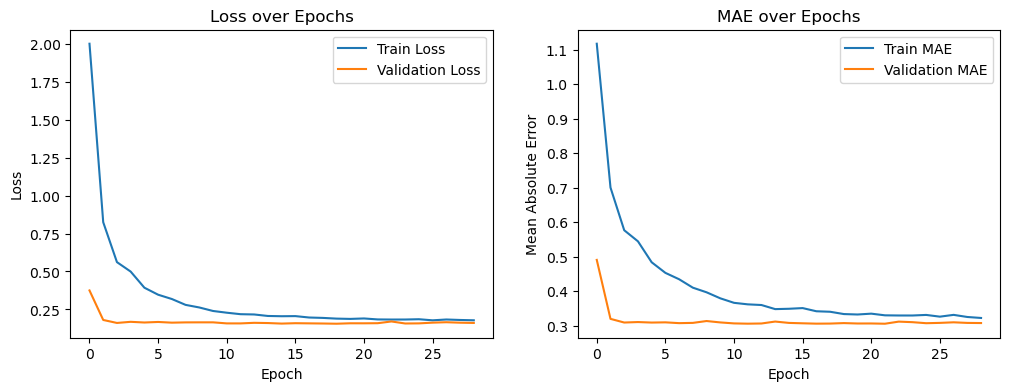

In [26]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('MAE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.show()

# Nachdem das Modell trainiert wurde
plot_learning_curves(history)

In [28]:
import joblib
import pickle
from tensorflow.keras.models import load_model

# Speichern des trainierten Keras-Modells
model.save("DNN_model_with_early_stopping.h5")

# Speichern der Trainingshistorie
with open("DNN_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Speichern der Leistungsmetriken (MSE und MAE)
performance_metrics = model.evaluate(X_test, y_test)
with open("DNN_performance_metrics.pkl", "wb") as f:
    pickle.dump(performance_metrics, f)




30/30 [==============================] - 0s 805us/step - loss: 0.1558 - mean_absolute_error: 0.3073
